# Description

This is documentation and scripts for the work *SciELO as a Scientometric research tool*, for presentation at the [STI2023 conference in Leiden](https://www.sti2023.org/).

The steps and scripts following aim at reproducibility, however they should include access to the commercial databases Scopus, Dimensions and Web of Science. Also, they need access to a working implementation of OpenAlex.

- [Scopus](scopus.com)
- [Dimensions](dimensions.ai)
- [Web of Science](webofscience.com)
- [OpenAlex](openalex.org)

All the steps can be implemented in a Google Big Query account. Other data warehouses can be used, with corresponding changes in the SQL scripts and import export steps must also be adapted.

The version hereafter presented applies to a situation in which the commercial databases are external and imported to our Big Query account through CSV files. The commercial databases are queried to create these tables with scripts here provided.



# Preparation

Steps to load Python modules and authentication.

- Check the project name in the follwing scripts.
- Check your access to Google Big Query using your google account.

If you are running this scripts inside the Google Colab Environment, the following snippets will provide access to your Google credentials in order to access Google Big Query. You should check if you have a Billing account to run the queries and that you have configured a project. By sure to access Big Query for the first time and follow instructions to check it. Also, change the project name in the cells for yours.

If you have no experience in Google Big Query, read:
(https://cloud.google.com/bigquery/docs/introduction).

The platform is accessible at
(https://cloud.google.com/bigquery).

If you want to have an introduction on how Google Colab notebooks interact with Big Query, see:
(https://colab.research.google.com/notebooks/bigquery.ipynb)

It also possible to run queries in Big Query from you local computer, preferably using an Anaconda Distribution installation (https://www.anaconda.com/download), to that effect, you should install and configure Google CLI (command-line-interface). The following instructions are made for that:

- Google CLI
https://cloud.google.com/cli?hl=pt-br
- Google Authentication
https://cloud.google.com/docs/authentication/provide-credentials-adc?hl=pt-br



In [ ]:
# Only if you are running in Colab. For locally running, follow instructions on
# local instalation of Python, Google Authentication.

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# Python modules

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from google.colab import files

## Scielo metadata as a dump

Compressed file with most of Scielo metadata provided by Scielo:

 http://static.scielo.org/articlemeta/scielo_articles.zip

 It comprises XML files, one for each work. They can be read into a table after converted to Python dictionaries. This work was already carried out and from this point on we will use our public table inside Big Query.

# Extract information from SciELO

- Check access to our public dataset
[InSySPo SciELO database](https://console.cloud.google.com/bigquery?project=insyspo&ws=!1m19!1m4!1m3!1sinsyspo!2sbquxjob_e97f491_1872e34fd8d!3sUS!1m4!4m3!1sinsyspo!2sprojectdb_scielo_rm!3sworks_fjs!1m4!4m3!1sinsyspo!2sprojectdb_scielo_rm!3sworks_json!1m3!3m2!1sinsyspo!2spublicdb_scielo&pli=1&authuser=3).
- Check if you are part of a project or create one yourself (https://cloud.google.com/resource-manager/docs/creating-managing-projects?hl=pt-br).
- Create a dataset for your use, as instructed here (https://cloud.google.com/bigquery/docs/datasets?hl=pt-br#console). In our scripts, we have used a dataset named `projectdb_scielo_scientometric_tool`.
- Collect IDs DOIs and publication year into a new table.
- From the table, count distinct IDs and distinct DOIs.
- You will probably have to create a project to host your data. If it is you first access, Google is currently providing a free tier of U$ 300.00, what is more than enough for what we do here and many other analyses. Otherwise, you may have to spend some money, according to Big Query prices (https://cloud.google.com/bigquery/pricing).

We have collected all the data from SciELO from a recent dump as a compacted file. Extracted it into a public dataset inside Big Query so everyone can access it.

We encourage you to check the link, see the table and even query it, if you have some SQL experience.

In the following, we provide the scripts to collect the table we need.

## About Big Query statements

When creating tables, we sometines add a `DROP TABLE` statement before. It only makes sense when rerunning to update the original table. In a very first execution you should not use this statement.

Know that tables are adressed as `project.dataset.table` or `dataset.table` when project is default or infered from environment.

When adressing tables inside Big Query, one can put the name inside grave accents `like.this` ou simply type the name. The symbol ` allows calling names with non-latin alphabets, accents and spaces. Names in latin alphabet without accents and spaces do not need that.

## Extract metadata


- Scielo identifier - id
- DOI - doi
- Publication year - pub_year
- SciELO collection - collection


In [ ]:
%%bigquery --project=insyspo

DROP TABLE IF EXISTS projectdb_scielo_scientometric_tool.works;
CREATE TABLE projectdb_scielo_scientometric_tool.works AS (
SELECT  TRIM(COALESCE( # several fields have been used to store the id.
          JSON_EXTRACT(
            works,
            '$.articles.article.front.article-meta.unique-article-id.text'),
          JSON_EXTRACT(
            works,
            '$.articles.article.front.article-meta.article-id[0].text'),
          JSON_EXTRACT(
            works,
            '$.articles.article.front.article-meta.article-id.text')
        ),'"') AS id,
        TRIM(JSON_EXTRACT(
          works,
          '$.articles.article.front.article-meta.article-id[1].text'),'"') AS doi,
        CAST(TRIM(JSON_EXTRACT(
          works,
          '$.articles.article.front.article-meta.pub-date.year'),'"') AS INT) AS pub_year,
        TRIM(JSON_EXTRACT(
          works,
          '$.articles.article.front.journal-meta.collection'),'"') AS collection,
FROM publicdb_scielo_2024.works_json
);


Query is running:   0%|          |

""


## Size statistics

Number or works, works with identifiers, works with DOIs, works with distinct DOIs.

In [ ]:
%%bigquery --project=insyspo

SELECT COUNT(doi) AS dois,
    COUNT(DISTINCT(doi)) AS distinct_dois,
    COUNT(DISTINCT(id)) AS distinct_ids,
    COUNT(*) AS total
FROM projectdb_scielo_scientometric_tool.works

Query is running:   0%|          |

Downloading:   0%|          |

,dois,distinct_dois,distinct_ids,total
0,0,0,0,1166515


## Trends in Scielo

In [ ]:
# Export yearly production to a Pandas dataframe.
%%bigquery df --project=insyspo

SELECT pub_year AS year,
    COUNT(DISTINCT(doi)) AS distinct_dois,
    COUNT(DISTINCT(id)) AS distinct_ids,
FROM projectdb_scielo_scientometric_tool.works
WHERE pub_year IS NOT NULL
GROUP BY pub_year
ORDER BY pub_year ASC


Query is running:   0%|          |

Downloading:   0%|          |

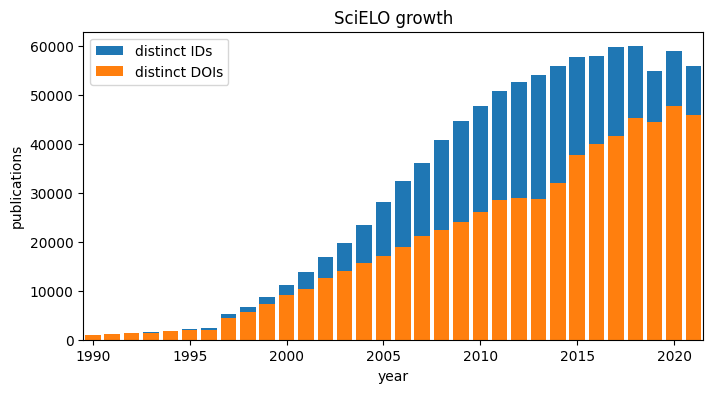

In [ ]:
x = df['year'].values
dois = df['distinct_dois'].values
ids = df['distinct_ids'].values

plt.figure(figsize=(8,4))
plt.bar(x,ids)
plt.bar(x,dois)
plt.xlim([1989.5,2021.5])
plt.title('SciELO growth')
plt.ylabel('publications')
plt.xlabel('year')
plt.legend(['distinct IDs','distinct DOIs'])

In [ ]:
df.to_csv('pubs_years.csv')
files.download('pubs_years.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

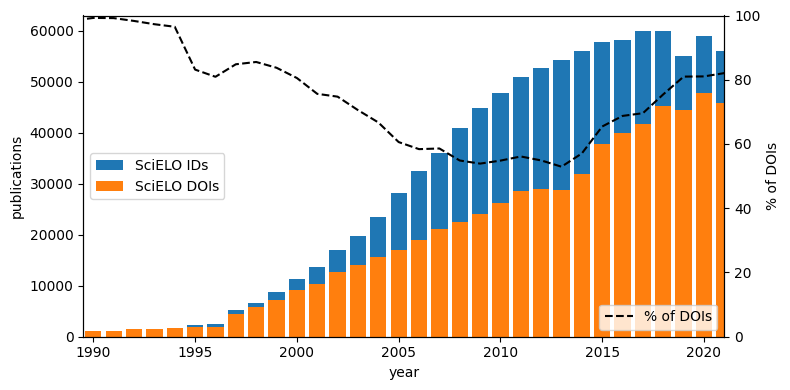

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))

#color = 'tab:red'
ax1.set_xlabel('year')
ax1.set_ylabel('publications')
ax1.bar(x, ids, label='SciELO IDs')
ax1.bar(x, dois, label='SciELO DOIs')
#ax1.tick_params(axis='y', labelcolor=color)
plt.legend(loc='center left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
ax2.set_ylabel('% of DOIs')  # we already handled the x-label with ax1
ax2.plot(x, 100*dois/ids,'--k',label='% of DOIs')
#ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,100)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xlim([1989.5,2021])
#plt.xlim([0,100])
plt.legend(loc='lower right')
plt.show()


# Collections in Scielo

In [ ]:
%%bigquery collections --project=insyspo

SELECT TRIM(collection,'"') AS collection, COUNT(doi) AS ndoi, COUNT(id) AS n, COUNT(doi)/COUNT(id) AS p
FROM `insyspo.projectdb_scielo_scientometric_tool.works`
GROUP BY collection
HAVING n>0
ORDER BY n DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
collections.to_csv('collections.csv')
files.download('collections.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

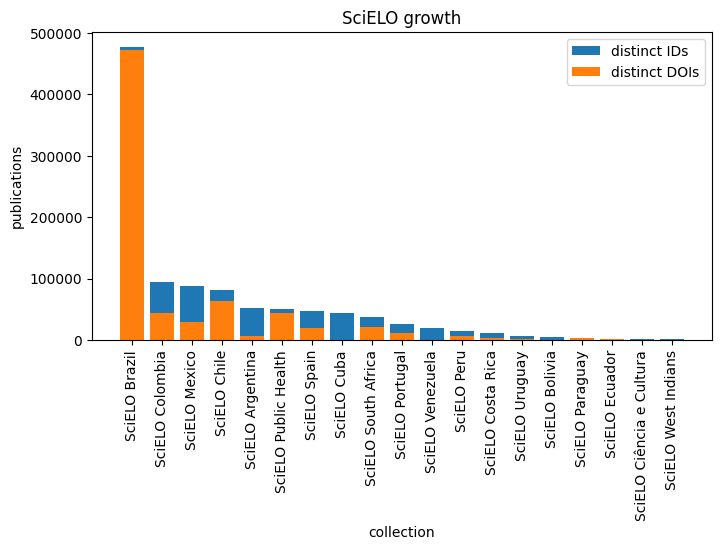

In [ ]:
x = collections['collection'].values
ids = collections['n'].values
dois = collections['ndoi'].values

plt.figure(figsize=(8,4))
plt.bar(x,ids)
plt.bar(x,dois)
plt.title('SciELO growth')
plt.ylabel('publications')
plt.xlabel('collection')
plt.xticks(rotation=90)
plt.legend(['distinct IDs','distinct DOIs'])

# Match works from Scielo into other databases

- Using DOIs, it is possible to match the works present in Scielo inside other databases.
- The code to match the DOIs is run with access to commercial databases. It is included here for documentation purposes and it cannot run inside the notebook. It was written in Microsoft SQL server, so the sintax is slightly different.

## Export Scielo table to be used externally

In [ ]:
%%bigquery df --project=insyspo

SELECT doi, pub_year, collection
FROM projectdb_scielo_scientometric_tool.works
WHERE doi IS NOT NULL
GROUP BY doi, collection, pub_year
ORDER BY pub_year DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df.head()

,doi,pub_year,collection
0,10.1590/1519-6984.251970,2024,SciELO Brazil
1,10.1590/1519-6984.249808,2024,SciELO Brazil
2,10.1590/1519-6984.251438,2024,SciELO Brazil
3,10.1590/1519-6984.249617,2024,SciELO Brazil
4,10.1590/1519-6984.253106,2024,SciELO Brazil


In [ ]:
from google.colab import files

df.to_csv('dois_scielo.csv', index=False)
files.download('dois_scielo.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Scripts to query commercial databases

The previously saved table is imported into a Microsoft SQL server table as `userdb_alyssonafm.dbo.dois_scielo`.

In [ ]:
# The %%bigquey statement is here solely for sintax highlighting.
%%bigquery
/* coverage of SciELO in other databases */
/* Dimensions */
SELECT COUNT(DISTINCT(b.doi))
FROM [userdb_alyssonafm].[dbo].[dois_scielo] AS a
LEFT JOIN dimensions_2022jun.dbo.pub AS b
ON a.doi = b.doi
/*  658234 */


/* WoS */
SELECT COUNT(DISTINCT(b.doi))
FROM userdb_alyssonafm.dbo.dois_scielo AS a
LEFT JOIN wos_2213.dbo.pub AS b
ON a.doi = b.doi
/* 224653 */


/* Scopus */
SELECT COUNT(DISTINCT(b.doi))
FROM userdb_alyssonafm.dbo.dois_scielo AS a
LEFT JOIN scopus_2022apr.dbo.pub AS b
ON a.doi = b.doi
/* 396405 */


/* coverage of SciELO collections in other databases */
SELECT collection,
	COUNT(DISTINCT(b.doi)) AS dimensions,
	COUNT(DISTINCT(c.doi)) AS wos,
	COUNT(DISTINCT(d.doi)) AS scopus
INTO [userdb_alyssonafm].[dbo].[coverage_scielo_colections]
FROM [userdb_alyssonafm].[dbo].[dois_scielo] AS a
LEFT JOIN dimensions_2022jun.dbo.pub AS b
ON a.doi = b.doi
LEFT JOIN wos_2213.dbo.pub AS c
ON a.doi = c.doi
LEFT JOIN scopus_2022apr.dbo.pub AS d
ON a.doi = d.doi
GROUP BY collection


/** trend analysis **/
 SELECT a.pub_year,
 COUNT(DISTINCT(b.doi)) AS dimensions,
 COUNT(DISTINCT(c.doi)) AS wos,
 COUNT(DISTINCT(d.doi)) AS scopus
INTO userdb_alyssonafm.dbo.trend_scielo_others
FROM userdb_alyssonafm.dbo.dois_scielo AS a
  LEFT JOIN dimensions_2022jun.dbo.pub AS b
  ON a.doi = b.doi
LEFT JOIN wos_2213.dbo.pub AS c
ON a.doi = c.doi
LEFT JOIN scopus_2022apr.dbo.pub AS d
ON a.doi = d.doi
GROUP BY a.pub_year

# The outputs is in the tables trend_scielo_others and coverage_scielo_collections,
# they are saved to csv files.

The output exported to csv files must be imported here. It can be done using Google drive folder. For our purposes, the tables are given as public links.

[Coverage in commercial databases](https://raw.githubusercontent.com/alyssonmazoni/scielo_scientometrics/main/trend_scielo_others.csv)

[Coverage of collections](https://raw.githubusercontent.com/alyssonmazoni/scielo_scientometrics/main/coverage_scielo_collections.csv)



In [ ]:
coverage_collections = pd.read_csv('https://raw.githubusercontent.com/alyssonmazoni/scielo_scientometrics/main/coverage_scielo_collections.csv',encoding='utf-16')
commercial_db = pd.read_csv('https://raw.githubusercontent.com/alyssonmazoni/scielo_scientometrics/main/trend_scielo_others.csv',encoding='utf-16')

In [ ]:
commercial_db = commercial_db.dropna()
commercial_db = commercial_db.astype({'year':int})

## OpenAlex

We have used a verion of OpenAlex updated up to April 2022 that is available as a public dataset in the link:

[Public OpenAlex by InSySPo](https://console.cloud.google.com/bigquery?project=insyspo&ws=!1m4!1m3!3m2!1sinsyspo!2spublicdb_openalex_2022_04&pli=1).

In [ ]:
%%bigquery openalex_db --project=insyspo

SELECT pub_year AS year,
    COUNT(DISTINCT(b.doi)) AS openalex,
    COUNT(DISTINCT(a.doi)) AS scielo,
    COUNT(DISTINCT(a.id)) AS total_scielo
FROM insyspo.projectdb_scielo_scientometric_tool.works AS a
LEFT JOIN insyspo.publicdb_openalex_2022_04.works AS b
ON LOWER(SUBSTR(b.doi,17)) = LOWER(a.doi)
WHERE pub_year IS NOT NULL
GROUP BY a.pub_year
ORDER BY a.pub_year ASC

Query is running:   0%|          |

Downloading:   0%|          |

## Comparison of presence of Scielo works in different databases


### Number of works

Text(0.5, 1.0, 'Works in SciELO each year')

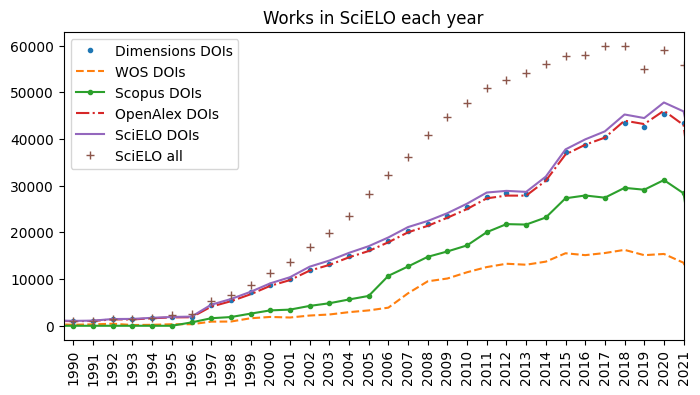

In [ ]:
x = commercial_db['year'].values
y1 = commercial_db['dimensions'].values
y2 = commercial_db['wos'].values
y3 = commercial_db['scopus'].values

x2 = openalex_db['year'].values
y4 = openalex_db['openalex'].values
y5 = openalex_db['scielo'].values
y6 = openalex_db['total_scielo'].values

plt.figure(figsize=(8,4))
plt.plot(x,y1,'.')
plt.plot(x,y2,'--')
plt.plot(x,y3,'.-')
plt.plot(x,y4,'-.')
plt.plot(x,y5,'-')
plt.plot(x,y6,'+')
plt.xticks(rotation=90)
plt.xlim([1989.5,2021])
plt.locator_params(axis='x', nbins=40)
plt.legend(['Dimensions DOIs','WOS DOIs','Scopus DOIs','OpenAlex DOIs',
            'SciELO DOIs','SciELO all'])
plt.title('Works in SciELO each year')

In [ ]:
dbs = pd.merge(openalex_db,commercial_db,on=['year','year'])
dbs['p_dimensions'] = dbs['dimensions']/dbs['scielo']
dbs['p_wos'] = dbs['wos']/dbs['scielo']
dbs['p_scopus'] = dbs['scopus']/dbs['scielo']
dbs['p_openalex'] = dbs['openalex']/dbs['scielo']

In [ ]:
dbs.tail()

,year,openalex,scielo,total_scielo,dimensions,wos,scopus,p_dimensions,p_wos,p_scopus,p_openalex
111,2020,46059,47818,59007,45349,15379,31203,0.948367,0.321615,0.652537,0.963215
112,2021,42981,45904,55936,43433,13492,28363,0.94617,0.293918,0.617876,0.936324
113,2022,8930,27001,30270,16982,1733,610,0.62894,0.064183,0.022592,0.330728
114,2023,228,567,567,8,5,9,0.014109,0.008818,0.015873,0.402116
115,2024,161,296,299,12,0,1,0.040541,0.0,0.003378,0.543919


In [ ]:
dbs.to_csv('scielo_dbs.csv')
files.download('scielo_dbs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Proportion of works

Text(0.5, 1.0, 'Presence of SciELO DOIs each year')

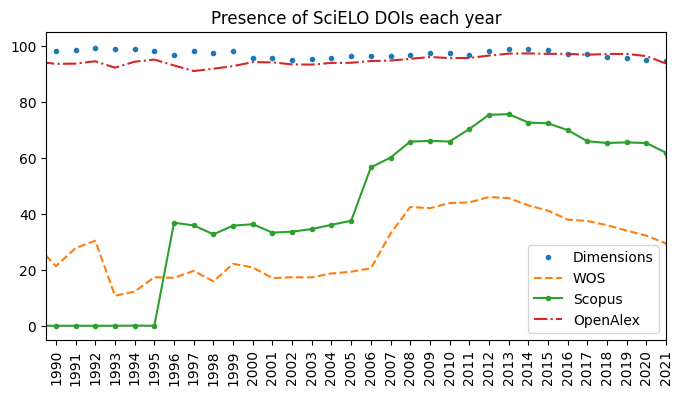

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(x,100*y1/y5,'.')
plt.plot(x,100*y2/y5,'--')
plt.plot(x,100*y3/y5,'.-')
plt.plot(x,100*y4/y5,'-.')
plt.xticks(rotation=90)
plt.xlim([1989.5,2021])
plt.locator_params(axis='x', nbins=40)
plt.legend(['Dimensions','WOS','Scopus','OpenAlex'])
plt.title('Presence of SciELO DOIs each year')

## Coverage in other databases by collection



In [ ]:
%%bigquery openalex_collections --project=insyspo

SELECT collection AS collection,
    COUNT(DISTINCT(b.doi)) AS openalex,
    COUNT(DISTINCT(a.doi)) AS scielo,
    COUNT(DISTINCT(a.id)) AS total_scielo
FROM insyspo.projectdb_scielo_scientometric_tool.works AS a
LEFT JOIN insyspo.publicdb_openalex_2022_04.works AS b
ON LOWER(SUBSTR(b.doi,17)) = LOWER(a.doi)
WHERE collection IS NOT NULL
GROUP BY a.collection
ORDER BY a.collection ASC

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
scielo_coverage_collections = pd.merge(coverage_collections, openalex_collections, on = ['collection','collection'])

In [ ]:
scielo_coverage_collections.head()
scielo_coverage_collections.to_csv('scielo_coverage_collections.csv')
files.download('scielo_coverage_collections.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

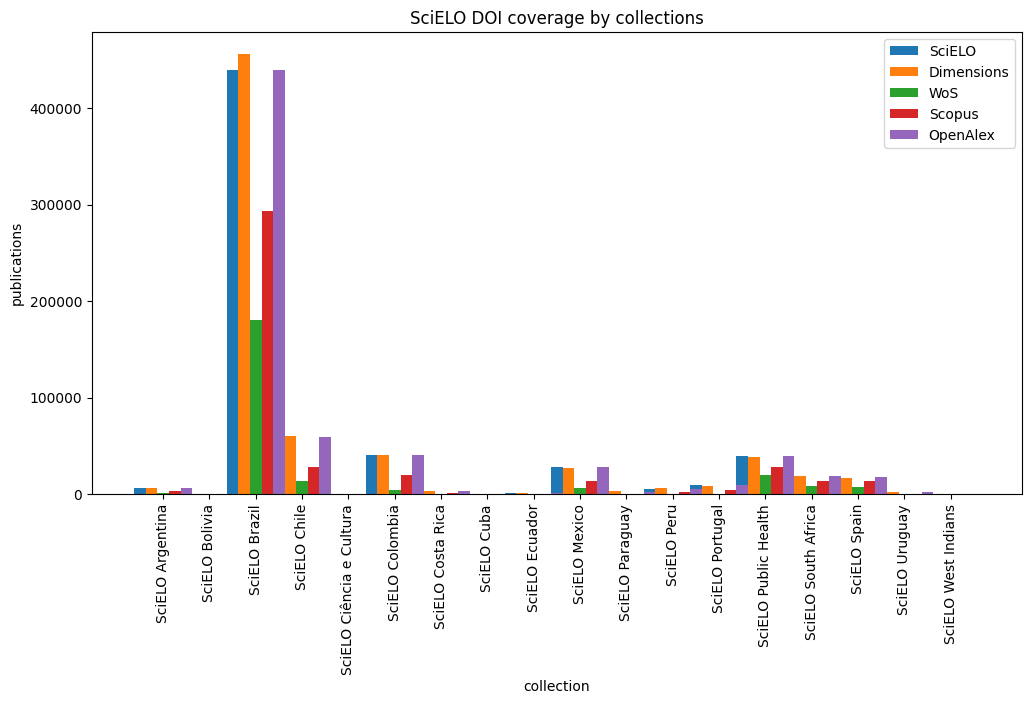

In [ ]:
df = scielo_coverage_collections
xticks = df['collection'].values
x = np.arange(len(xticks))
y = df['dimensions'].values
z = df['wos'].values
w = df['scopus'].values
o = df['openalex'].values
s = df['scielo'].values
width = 0.2
offset = 0.2

plt.figure(figsize=(12,6))
plt.bar(x-2*offset,o, width, label='SciELO')
plt.bar(x-offset,y, width, label='Dimensions')
plt.bar(x,z, width, label='WoS')
plt.bar(x+offset,w, width, label='Scopus')
plt.bar(x+2*offset,o, width, label='OpenAlex')

plt.title('SciELO DOI coverage by collections')
plt.ylabel('publications')
plt.xlabel('collection')
plt.xticks(x, labels=xticks, rotation=90)
plt.legend()